In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                            | 0/60000 [00:00<?, ?it/s]

 13%|███████▊                                                      | 7602/60000 [00:00<00:00, 76010.47it/s]

 25%|███████████████▍                                             | 15204/60000 [00:00<00:00, 75341.80it/s]

 38%|███████████████████████▎                                     | 22886/60000 [00:00<00:00, 76010.81it/s]

 51%|███████████████████████████████                              | 30529/60000 [00:00<00:00, 76172.55it/s]

 64%|██████████████████████████████████████▊                      | 38147/60000 [00:00<00:00, 72416.75it/s]

 76%|██████████████████████████████████████████████▍              | 45704/60000 [00:00<00:00, 73449.67it/s]

 88%|█████████████████████████████████████████████████████▉       | 53079/60000 [00:00<00:00, 73542.16it/s]

100%|█████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 73842.47it/s]

  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████▎              | 7637/10000 [00:00<00:00, 76363.34it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 75701.12it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 ho6dji6w


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-ho6dji6w:best, 409.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.8


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/383 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/383 [00:00<03:40,  1.73it/s]

  2%|█▋                                                                    | 9/383 [00:00<00:21, 17.10it/s]

  4%|███                                                                  | 17/383 [00:00<00:11, 30.55it/s]

  7%|████▌                                                                | 25/383 [00:00<00:08, 41.85it/s]

  9%|█████▉                                                               | 33/383 [00:00<00:06, 51.02it/s]

 11%|███████▍                                                             | 41/383 [00:01<00:05, 58.12it/s]

 13%|████████▊                                                            | 49/383 [00:01<00:05, 63.10it/s]

 15%|██████████▎                                                          | 57/383 [00:01<00:04, 66.68it/s]

 17%|███████████▋                                                         | 65/383 [00:01<00:04, 69.37it/s]

 19%|█████████████▏                                                       | 73/383 [00:01<00:04, 71.76it/s]

 21%|██████████████▌                                                      | 81/383 [00:01<00:04, 72.70it/s]

 23%|████████████████                                                     | 89/383 [00:01<00:03, 74.14it/s]

 25%|█████████████████▍                                                   | 97/383 [00:01<00:03, 74.53it/s]

 27%|██████████████████▋                                                 | 105/383 [00:01<00:03, 75.41it/s]

 30%|████████████████████                                                | 113/383 [00:02<00:03, 75.38it/s]

 32%|█████████████████████▍                                              | 121/383 [00:02<00:03, 75.99it/s]

 34%|██████████████████████▉                                             | 129/383 [00:02<00:03, 76.13it/s]

 36%|████████████████████████▎                                           | 137/383 [00:02<00:03, 76.00it/s]

 38%|█████████████████████████▋                                          | 145/383 [00:02<00:03, 76.48it/s]

 40%|███████████████████████████▏                                        | 153/383 [00:02<00:03, 76.15it/s]

 42%|████████████████████████████▌                                       | 161/383 [00:02<00:02, 76.55it/s]

 44%|██████████████████████████████                                      | 169/383 [00:02<00:02, 76.21it/s]

 46%|███████████████████████████████▍                                    | 177/383 [00:02<00:02, 76.63it/s]

 48%|████████████████████████████████▊                                   | 185/383 [00:02<00:02, 76.25it/s]

 50%|██████████████████████████████████▎                                 | 193/383 [00:03<00:02, 76.63it/s]

 52%|███████████████████████████████████▋                                | 201/383 [00:03<00:02, 76.25it/s]

 55%|█████████████████████████████████████                               | 209/383 [00:03<00:02, 76.66it/s]

 57%|██████████████████████████████████████▌                             | 217/383 [00:03<00:02, 76.23it/s]

 59%|███████████████████████████████████████▉                            | 225/383 [00:03<00:02, 76.67it/s]

 61%|█████████████████████████████████████████▎                          | 233/383 [00:03<00:01, 76.27it/s]

 63%|██████████████████████████████████████████▊                         | 241/383 [00:03<00:01, 75.48it/s]

 65%|████████████████████████████████████████████▏                       | 249/383 [00:03<00:01, 76.04it/s]

 67%|█████████████████████████████████████████████▋                      | 257/383 [00:03<00:01, 75.89it/s]

 69%|███████████████████████████████████████████████                     | 265/383 [00:04<00:01, 76.41it/s]

 71%|████████████████████████████████████████████████▍                   | 273/383 [00:04<00:01, 76.21it/s]

 73%|█████████████████████████████████████████████████▉                  | 281/383 [00:04<00:01, 75.91it/s]

 75%|███████████████████████████████████████████████████▎                | 289/383 [00:04<00:01, 76.50it/s]

 78%|████████████████████████████████████████████████████▋               | 297/383 [00:04<00:01, 76.14it/s]

 80%|██████████████████████████████████████████████████████▏             | 305/383 [00:04<00:01, 76.57it/s]

 82%|███████████████████████████████████████████████████████▌            | 313/383 [00:04<00:00, 76.21it/s]

 84%|████████████████████████████████████████████████████████▉           | 321/383 [00:04<00:00, 76.65it/s]

 86%|██████████████████████████████████████████████████████████▍         | 329/383 [00:04<00:00, 76.23it/s]

 88%|███████████████████████████████████████████████████████████▊        | 337/383 [00:04<00:00, 76.63it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 345/383 [00:05<00:00, 76.28it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 353/383 [00:05<00:00, 76.68it/s]

 94%|████████████████████████████████████████████████████████████████    | 361/383 [00:05<00:00, 76.24it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 369/383 [00:05<00:00, 76.64it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 377/383 [00:05<00:00, 76.26it/s]

100%|████████████████████████████████████████████████████████████████████| 383/383 [00:05<00:00, 67.99it/s]

train - OK


  0%|                                                                               | 0/96 [00:00<?, ?it/s]

  3%|██▏                                                                    | 3/96 [00:00<00:03, 28.86it/s]

 11%|████████                                                              | 11/96 [00:00<00:01, 57.34it/s]

 20%|█████████████▊                                                        | 19/96 [00:00<00:01, 65.66it/s]

 28%|███████████████████▋                                                  | 27/96 [00:00<00:00, 69.68it/s]

 36%|█████████████████████████▌                                            | 35/96 [00:00<00:00, 71.72it/s]

 45%|███████████████████████████████▎                                      | 43/96 [00:00<00:00, 73.65it/s]

 53%|█████████████████████████████████████▏                                | 51/96 [00:00<00:00, 74.22it/s]

 61%|███████████████████████████████████████████                           | 59/96 [00:00<00:00, 75.30it/s]

 70%|████████████████████████████████████████████████▊                     | 67/96 [00:00<00:00, 75.35it/s]

 78%|██████████████████████████████████████████████████████▋               | 75/96 [00:01<00:00, 75.99it/s]

 86%|████████████████████████████████████████████████████████████▌         | 83/96 [00:01<00:00, 75.80it/s]

 95%|██████████████████████████████████████████████████████████████████▎   | 91/96 [00:01<00:00, 76.39it/s]

100%|██████████████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 69.79it/s]

val - OK


  0%|                                                                               | 0/81 [00:00<?, ?it/s]

  4%|██▋                                                                    | 3/81 [00:00<00:02, 29.43it/s]

 14%|█████████▌                                                            | 11/81 [00:00<00:01, 57.27it/s]

 23%|████████████████▍                                                     | 19/81 [00:00<00:00, 66.50it/s]

 37%|█████████████████████████▉                                            | 30/81 [00:00<00:00, 82.40it/s]

 54%|█████████████████████████████████████▍                               | 44/81 [00:00<00:00, 102.13it/s]

 72%|█████████████████████████████████████████████████▍                   | 58/81 [00:00<00:00, 113.95it/s]

 89%|█████████████████████████████████████████████████████████████▎       | 72/81 [00:00<00:00, 121.15it/s]

100%|██████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 95.90it/s]

test InD - OK


  0%|                                                                              | 0/536 [00:00<?, ?it/s]

  1%|▋                                                                     | 5/536 [00:00<00:11, 47.60it/s]

  4%|██▍                                                                  | 19/536 [00:00<00:05, 98.82it/s]

  5%|███▋                                                                 | 29/536 [00:00<00:05, 91.68it/s]

  7%|█████                                                                | 39/536 [00:00<00:05, 83.90it/s]

  9%|██████▏                                                              | 48/536 [00:00<00:05, 81.63it/s]

 11%|███████▎                                                             | 57/536 [00:00<00:05, 80.11it/s]

 12%|████████▍                                                            | 66/536 [00:00<00:05, 78.60it/s]

 14%|█████████▌                                                           | 74/536 [00:00<00:05, 78.34it/s]

 15%|██████████▌                                                          | 82/536 [00:01<00:05, 77.57it/s]

 17%|███████████▌                                                         | 90/536 [00:01<00:05, 76.86it/s]

 18%|████████████▌                                                        | 98/536 [00:01<00:05, 77.10it/s]

 20%|█████████████▍                                                      | 106/536 [00:01<00:05, 76.54it/s]

 21%|██████████████▍                                                     | 114/536 [00:01<00:05, 76.83it/s]

 23%|███████████████▍                                                    | 122/536 [00:01<00:05, 76.38it/s]

 24%|████████████████▍                                                   | 130/536 [00:01<00:05, 76.77it/s]

 26%|█████████████████▌                                                  | 138/536 [00:01<00:05, 76.36it/s]

 27%|██████████████████▌                                                 | 146/536 [00:01<00:05, 76.68it/s]

 29%|███████████████████▌                                                | 154/536 [00:01<00:05, 76.26it/s]

 30%|████████████████████▌                                               | 162/536 [00:02<00:04, 76.69it/s]

 32%|█████████████████████▌                                              | 170/536 [00:02<00:04, 76.24it/s]

 33%|██████████████████████▌                                             | 178/536 [00:02<00:04, 76.66it/s]

 35%|███████████████████████▌                                            | 186/536 [00:02<00:04, 76.28it/s]

 36%|████████████████████████▌                                           | 194/536 [00:02<00:04, 76.65it/s]

 38%|█████████████████████████▋                                          | 202/536 [00:02<00:04, 76.23it/s]

 39%|██████████████████████████▋                                         | 210/536 [00:02<00:04, 76.62it/s]

 41%|███████████████████████████▋                                        | 218/536 [00:02<00:04, 76.36it/s]

 42%|████████████████████████████▋                                       | 226/536 [00:02<00:04, 76.03it/s]

 44%|█████████████████████████████▋                                      | 234/536 [00:03<00:03, 76.52it/s]

 45%|██████████████████████████████▋                                     | 242/536 [00:03<00:03, 76.11it/s]

 47%|███████████████████████████████▋                                    | 250/536 [00:03<00:03, 76.53it/s]

 48%|████████████████████████████████▋                                   | 258/536 [00:03<00:03, 76.15it/s]

 50%|█████████████████████████████████▋                                  | 266/536 [00:03<00:03, 76.59it/s]

 51%|██████████████████████████████████▊                                 | 274/536 [00:03<00:03, 76.22it/s]

 53%|███████████████████████████████████▊                                | 282/536 [00:03<00:03, 76.59it/s]

 54%|████████████████████████████████████▊                               | 290/536 [00:03<00:03, 76.22it/s]

 56%|█████████████████████████████████████▊                              | 298/536 [00:03<00:03, 76.61it/s]

 57%|██████████████████████████████████████▊                             | 306/536 [00:03<00:03, 76.14it/s]

 59%|███████████████████████████████████████▊                            | 314/536 [00:04<00:02, 76.55it/s]

 60%|████████████████████████████████████████▊                           | 322/536 [00:04<00:02, 76.22it/s]

 62%|█████████████████████████████████████████▊                          | 330/536 [00:04<00:02, 76.59it/s]

 63%|██████████████████████████████████████████▉                         | 338/536 [00:04<00:02, 76.23it/s]

 65%|███████████████████████████████████████████▉                        | 346/536 [00:04<00:02, 76.68it/s]

 66%|████████████████████████████████████████████▉                       | 354/536 [00:04<00:02, 76.39it/s]

 68%|█████████████████████████████████████████████▉                      | 362/536 [00:04<00:02, 76.01it/s]

 69%|██████████████████████████████████████████████▉                     | 370/536 [00:04<00:02, 76.51it/s]

 71%|███████████████████████████████████████████████▉                    | 378/536 [00:04<00:02, 76.12it/s]

 72%|████████████████████████████████████████████████▉                   | 386/536 [00:05<00:01, 76.50it/s]

 74%|█████████████████████████████████████████████████▉                  | 394/536 [00:05<00:01, 76.15it/s]

 75%|███████████████████████████████████████████████████                 | 402/536 [00:05<00:01, 76.52it/s]

 76%|████████████████████████████████████████████████████                | 410/536 [00:05<00:01, 76.22it/s]

 78%|█████████████████████████████████████████████████████               | 418/536 [00:05<00:01, 76.61it/s]

 79%|██████████████████████████████████████████████████████              | 426/536 [00:05<00:01, 76.26it/s]

 81%|███████████████████████████████████████████████████████             | 434/536 [00:05<00:01, 76.68it/s]

 82%|████████████████████████████████████████████████████████            | 442/536 [00:05<00:01, 76.26it/s]

 84%|█████████████████████████████████████████████████████████           | 450/536 [00:05<00:01, 76.66it/s]

 85%|██████████████████████████████████████████████████████████          | 458/536 [00:05<00:01, 76.27it/s]

 87%|███████████████████████████████████████████████████████████         | 466/536 [00:06<00:00, 76.65it/s]

 88%|████████████████████████████████████████████████████████████▏       | 474/536 [00:06<00:00, 76.24it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 482/536 [00:06<00:00, 76.67it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 490/536 [00:06<00:00, 76.38it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 498/536 [00:06<00:00, 76.03it/s]

 94%|████████████████████████████████████████████████████████████████▏   | 506/536 [00:06<00:00, 76.51it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 514/536 [00:06<00:00, 76.14it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 522/536 [00:06<00:00, 76.53it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 530/536 [00:06<00:00, 76.17it/s]

100%|████████████████████████████████████████████████████████████████████| 536/536 [00:07<00:00, 76.30it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:01, 77.03it/s]

 16%|███████████                                                          | 16/100 [00:00<00:01, 77.35it/s]

 24%|████████████████▌                                                    | 24/100 [00:00<00:00, 76.42it/s]

 32%|██████████████████████                                               | 32/100 [00:00<00:00, 76.18it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:00<00:00, 75.89it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:00<00:00, 76.49it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:00<00:00, 76.14it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:00<00:00, 76.58it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:00<00:00, 76.25it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:01<00:00, 76.70it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:01<00:00, 75.58it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:01<00:00, 75.53it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 76.24it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(24476, 3, 32, 32) (24476, 2048) (24476, 256) (24476, 5) (24476,)
(6120, 3, 32, 32) (6120, 2048) (6120, 256) (6120, 5) (6120,)
(5139, 3, 32, 32) (5139, 2048) (5139, 256) (5139, 5) (5139,)
(34265, 3, 32, 32) (34265, 2048) (34265, 256) (34265, 5) (34265,)
(6400, 3, 32, 32) (6400, 2048) (6400, 256) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5139, 2) (34265, 2)


(5139, 2) (34265, 2)


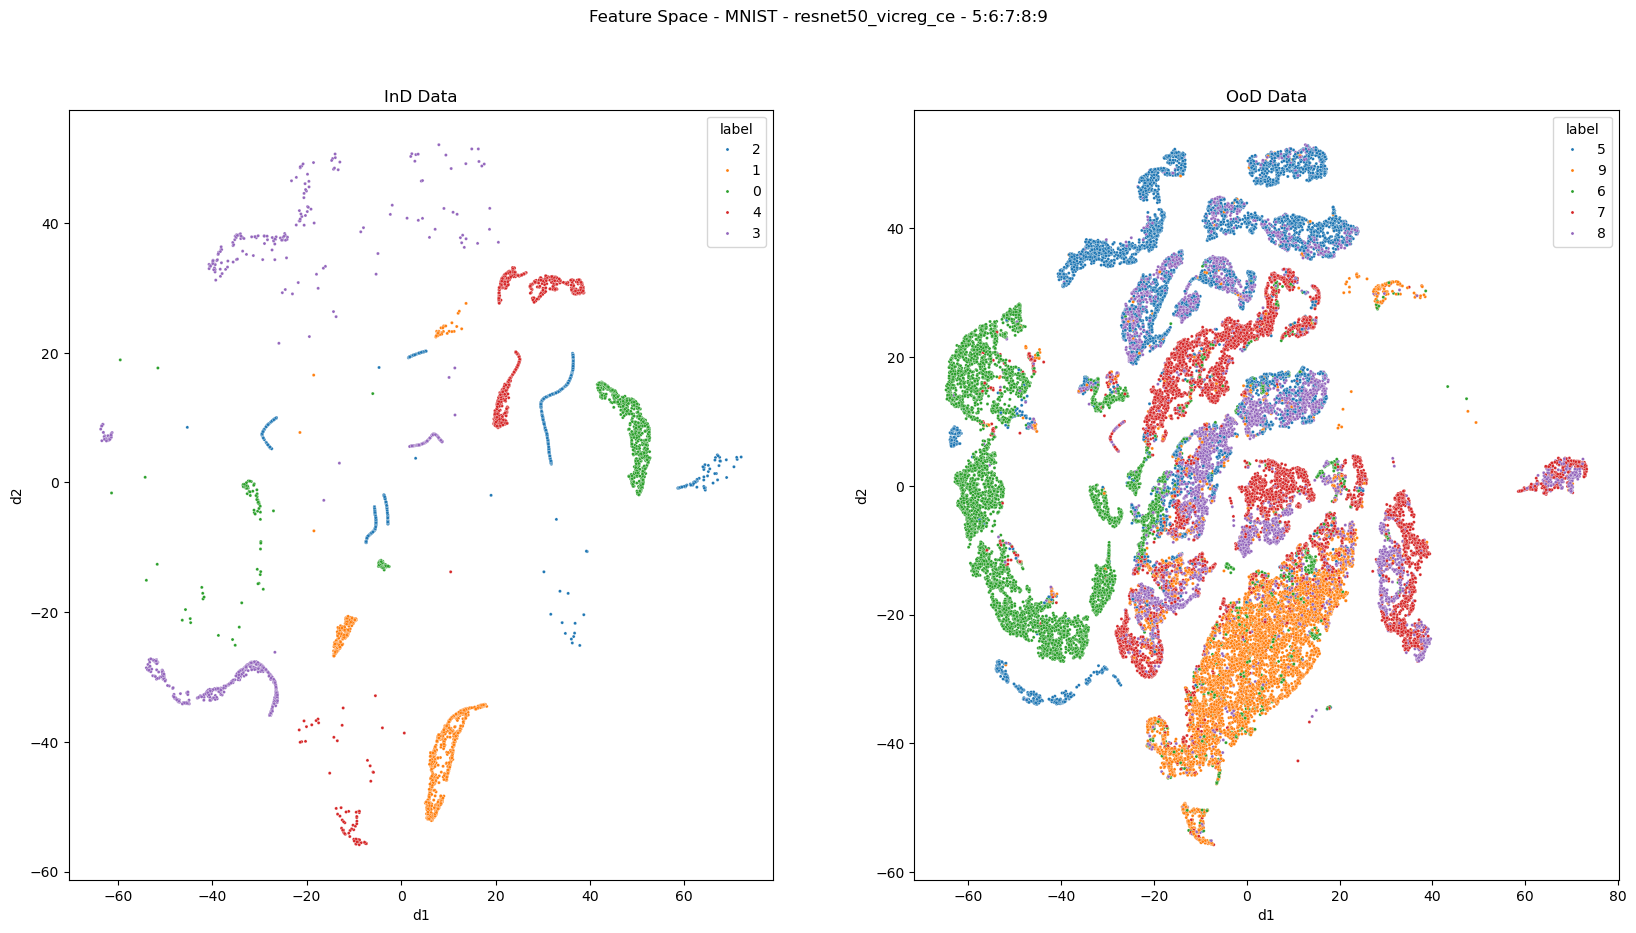

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

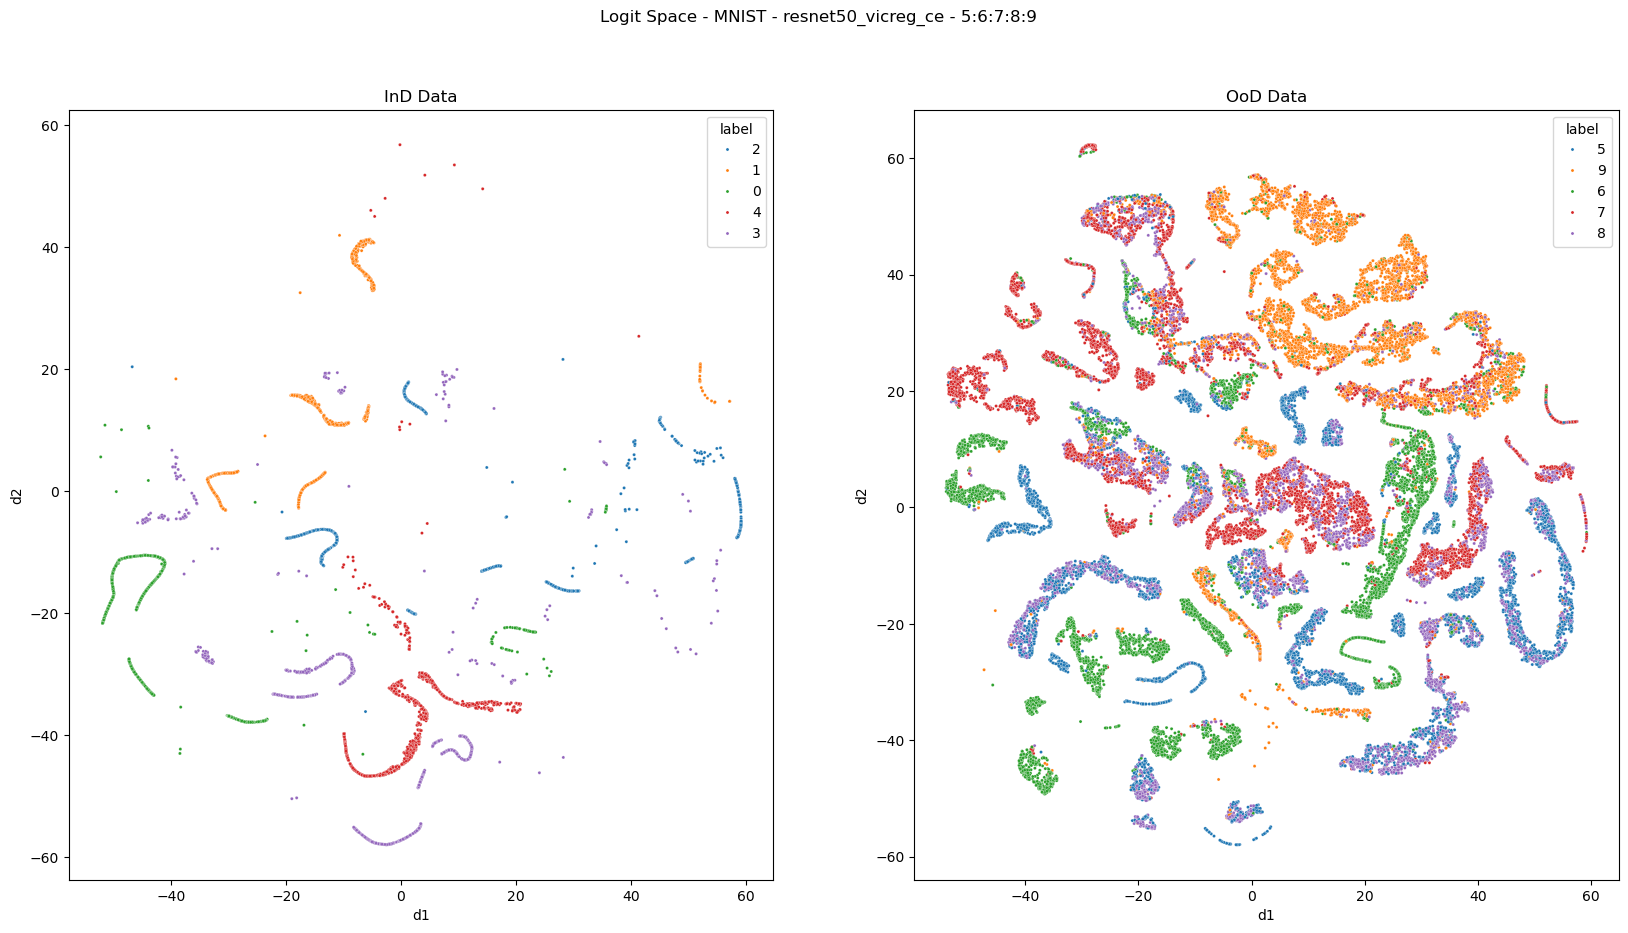

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:06<00:19,  6.40s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:12<00:12,  6.33s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:19<00:06,  6.37s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.44s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.41s/it]

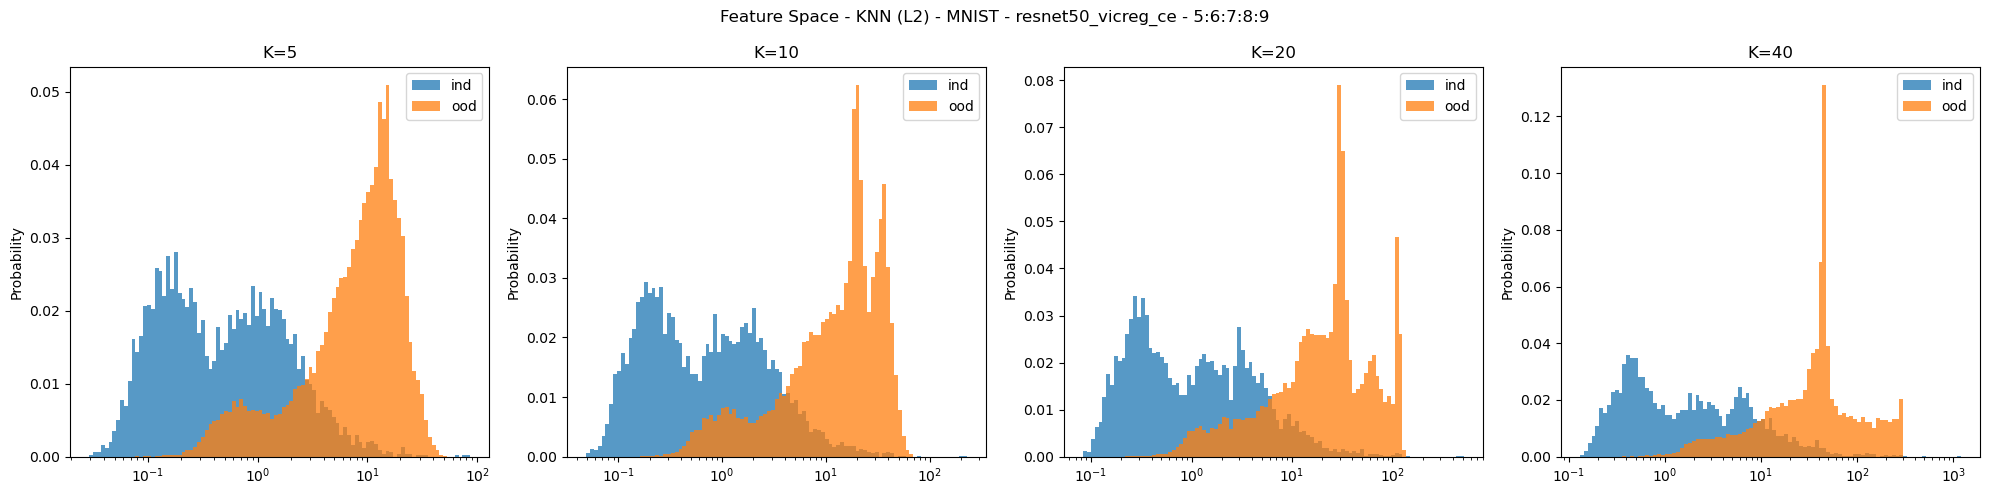

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:06<00:18,  6.18s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:12<00:12,  6.20s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:18<00:06,  6.34s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.41s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.35s/it]

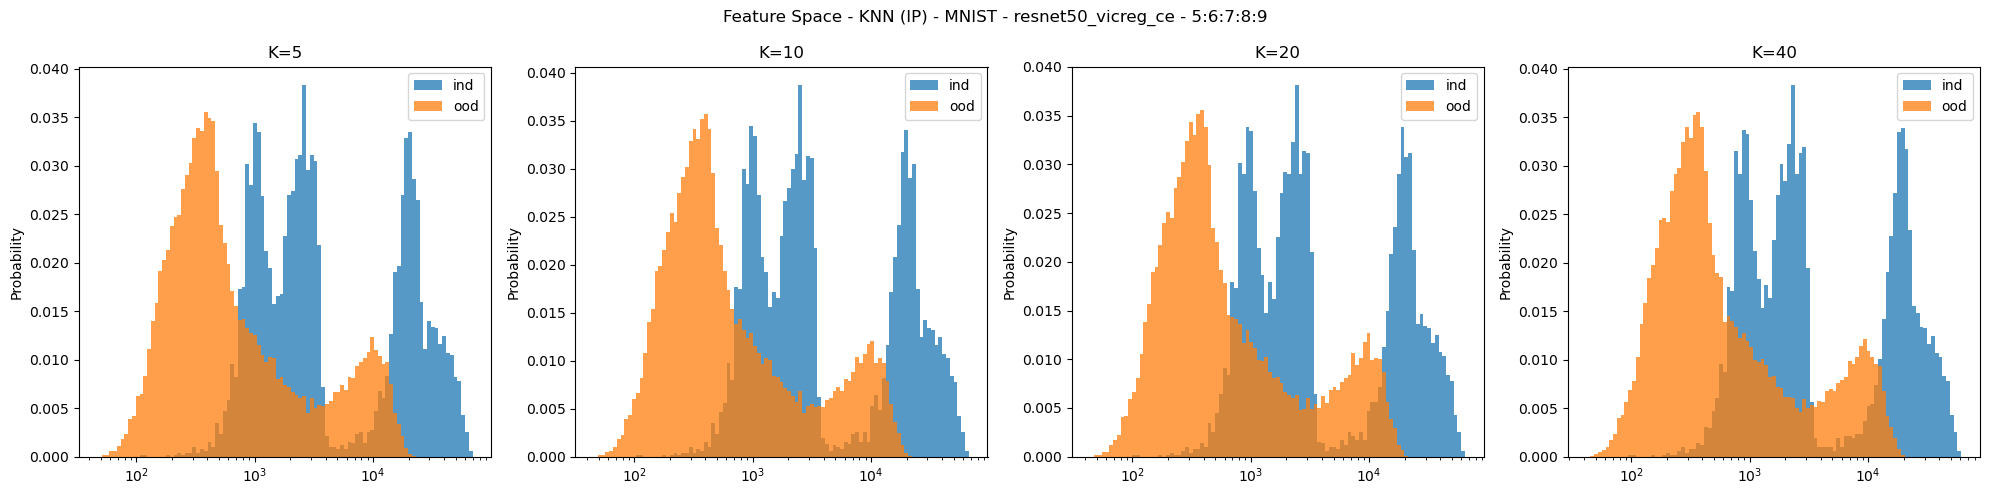

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.80it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.61it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.31it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.89it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]

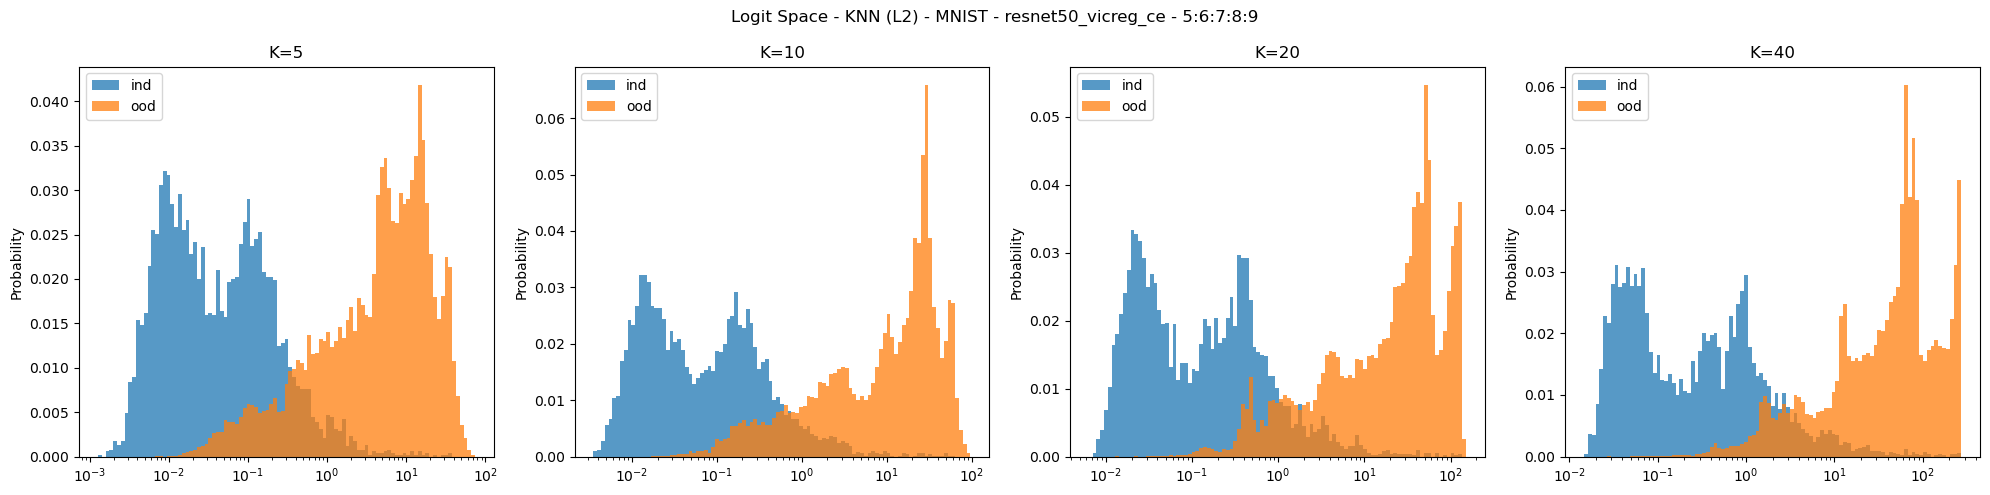

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  3.16it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  3.04it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.71it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]

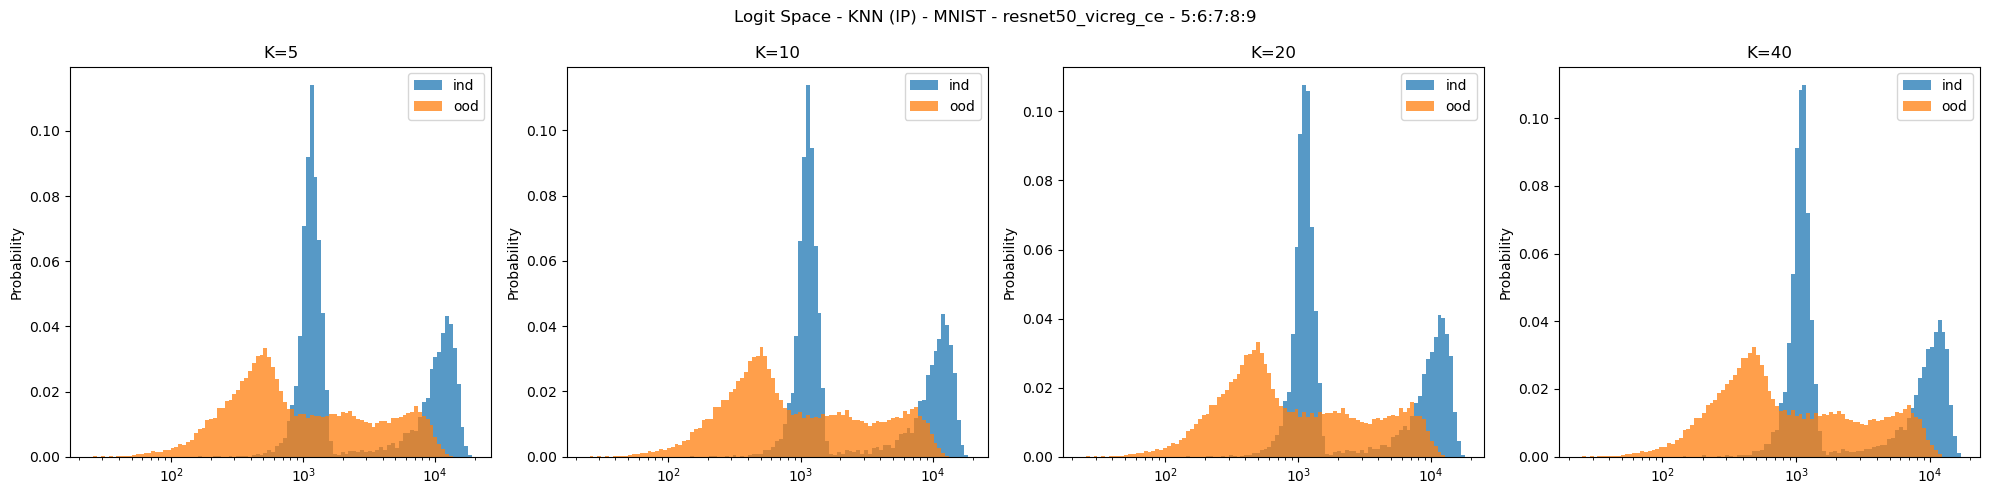

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

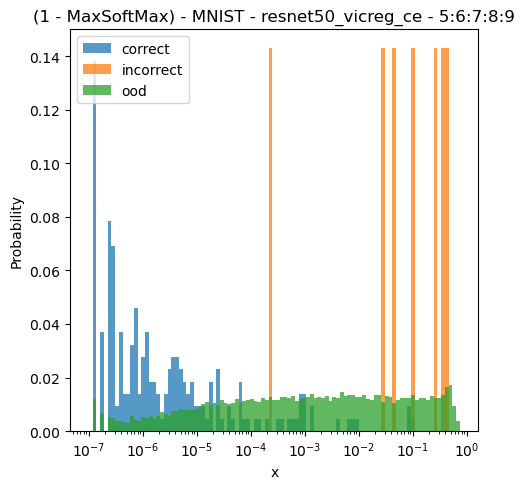

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()